# Problem: Loading 4D variables and writing output to zarr


In [1]:
pip install xmip

Note: you may need to restart the kernel to use updated packages.


## Import packages

In [1]:
import numpy as np
import xarray as xr
import dask
import s3fs
import zarr
import warnings
import xmip.preprocessing as xmip
warnings.filterwarnings('ignore')

## Create a new Dask cluster with the Dask Gateway

In [2]:
from dask_gateway import Gateway
gateway = Gateway()

In [4]:
##A line of trick to clean your dask cluster before you start your computation
from dask.distributed import Client
clusters=gateway.list_clusters()
print(clusters )
for cluster in clusters :
    cluster= gateway.connect(cluster.name)
    print(cluster)
    client = Client(cluster)
    client.close()
    cluster.shutdown()

[]


In [5]:
cluster = gateway.new_cluster(worker_memory=8, worker_cores=2)

cluster.scale(40)
cluster

## Get a client from the Dask Gateway Cluster

As stated above, creating a Dask `Client` is mandatory in order to perform following Daks computations on your Dask Cluster.

In [6]:
from distributed import Client

if cluster:
    client = Client(cluster) # create a dask Gateway cluster
else:
    client = Client()   # create a local dask cluster on the machine.
client

Connection method: Cluster object,Cluster type: dask_gateway.GatewayCluster
Dashboard: /jupyterhub/services/dask-gateway/clusters/daskhub.ea12b37923b24b18b43da16631c427a8/status,


## Open dictionary of OMIP2 simulations
With file lists taken from the ESGF Search Catalog with the following search requirements:
1. On the native grid
2. Have the varaibles:`umo`, `vmo`, `so`, `thetao`, `zos`, `mlotst`, `siconc`, `deptho`, `areacello`
3. At monthly time steps
4. The last 61 years of the simulation

In [43]:
# Load in file of model names and fnames
model_fnames_dict = np.load("models.npy", allow_pickle=True).item()


['http://esgf-data1.llnl.gov/thredds/dodsC/css03_data/CMIP6/OMIP/CMCC/CMCC-CM2-SR5/omip1/r1i1p1f1/Ofx/areacello/gn/v20200226/areacello_Ofx_CMCC-CM2-SR5_omip1_r1i1p1f1_gn.nc', 'http://esgf-data1.llnl.gov/thredds/dodsC/css03_data/CMIP6/OMIP/CMCC/CMCC-CM2-SR5/omip1/r1i1p1f1/Ofx/deptho/gn/v20200226/deptho_Ofx_CMCC-CM2-SR5_omip1_r1i1p1f1_gn.nc', 'http://esgf-data1.llnl.gov/thredds/dodsC/css03_data/CMIP6/OMIP/CMCC/CMCC-CM2-SR5/omip2/r1i1p1f1/Omon/vmo/gn/v20200226/vmo_Omon_CMCC-CM2-SR5_omip2_r1i1p1f1_gn_195801-201812.nc', 'http://esgf-data1.llnl.gov/thredds/dodsC/css03_data/CMIP6/OMIP/CMCC/CMCC-CM2-SR5/omip2/r1i1p1f1/Omon/thetao/gn/v20200226/thetao_Omon_CMCC-CM2-SR5_omip2_r1i1p1f1_gn_195801-201812.nc', 'http://esgf-data1.llnl.gov/thredds/dodsC/css03_data/CMIP6/OMIP/CMCC/CMCC-CM2-SR5/omip2/r1i1p1f1/Omon/so/gn/v20200226/so_Omon_CMCC-CM2-SR5_omip2_r1i1p1f1_gn_195801-201812.nc', 'http://esgf-data1.llnl.gov/thredds/dodsC/css03_data/CMIP6/OMIP/CMCC/CMCC-CM2-SR5/omip2/r1i1p1f1/Omon/umo/gn/v20200226/

['http://esgf-data1.llnl.gov/thredds/fileServer/css03_data/CMIP6/OMIP/CMCC/CMCC-CM2-SR5/omip1/r1i1p1f1/Ofx/areacello/gn/v20200226/areacello_Ofx_CMCC-CM2-SR5_omip1_r1i1p1f1_gn.nc',
 'http://esgf-data1.llnl.gov/thredds/fileServer/css03_data/CMIP6/OMIP/CMCC/CMCC-CM2-SR5/omip1/r1i1p1f1/Ofx/deptho/gn/v20200226/deptho_Ofx_CMCC-CM2-SR5_omip1_r1i1p1f1_gn.nc',
 'http://esgf-data1.llnl.gov/thredds/fileServer/css03_data/CMIP6/OMIP/CMCC/CMCC-CM2-SR5/omip2/r1i1p1f1/Omon/vmo/gn/v20200226/vmo_Omon_CMCC-CM2-SR5_omip2_r1i1p1f1_gn_195801-201812.nc',
 'http://esgf-data1.llnl.gov/thredds/fileServer/css03_data/CMIP6/OMIP/CMCC/CMCC-CM2-SR5/omip2/r1i1p1f1/Omon/thetao/gn/v20200226/thetao_Omon_CMCC-CM2-SR5_omip2_r1i1p1f1_gn_195801-201812.nc',
 'http://esgf-data1.llnl.gov/thredds/fileServer/css03_data/CMIP6/OMIP/CMCC/CMCC-CM2-SR5/omip2/r1i1p1f1/Omon/so/gn/v20200226/so_Omon_CMCC-CM2-SR5_omip2_r1i1p1f1_gn_195801-201812.nc',
 'http://esgf-data1.llnl.gov/thredds/fileServer/css03_data/CMIP6/OMIP/CMCC/CMCC-CM2-SR5/om

## Function for writing zarr file to bucket

In [8]:
def write_dataset_to_zarr(ds,sim_name):
    # set path on bucket
    path='WAFFLES/OMIP2/'
    s3_prefix = "s3://" + path
    print(s3_prefix)
    
    # get storage keys
    access_key = !aws configure get aws_access_key_id
    access_key = access_key[0]
    secret_key = !aws configure get aws_secret_access_key
    secret_key = secret_key[0]
    
    # set storage target
    client_kwargs = {'endpoint_url': 'https://object-store.cloud.muni.cz'}
    target = s3fs.S3FileSystem(anon=False,client_kwargs=client_kwargs)
    
    # make file name for variable in simulation
    zarr_file_name = sim_name
    uri = f"{s3_prefix}/{zarr_file_name}"
    
    # get store argument for zarr
    store = zarr.storage.FSStore(uri,client_kwargs=client_kwargs,
                                 key=access_key, secret=secret_key)
    
    # write variable to zarr
    %time ds.to_zarr(store=store,mode='w',consolidated=True)
    
    return

## Function for reading from zarr bucket

In [9]:
def read_dataset_from_zarr(sim_name):
    # set path on bucket
    path='WAFFLES/OMIP2/'
    s3_prefix = "s3://" + path
    print(s3_prefix)
    
    # get storage keys
    access_key = !aws configure get aws_access_key_id
    access_key = access_key[0]
    secret_key = !aws configure get aws_secret_access_key
    secret_key = secret_key[0]
    
    # set storage target
    client_kwargs={'endpoint_url': 'https://object-store.cloud.muni.cz'}
    target = s3fs.S3FileSystem(anon=False,client_kwargs=client_kwargs)
    
    # file name for simulation
    zarr_file_name = sim_name
    uri = f"{s3_prefix}/{zarr_file_name}"
    
    # get store argument for zarr
    store = zarr.storage.FSStore(uri,client_kwargs=client_kwargs,
                                 key=access_key, secret=secret_key)
    
    # read variable from zarr
    ds=xr.open_zarr(store=store)
    
    return ds

## Function for loading data from ESGF node

In [44]:
def reindex_lat(ds):
    # check if lat is decreasing
    if ds.lat.isel(x=0,y=0) > 0:
        ds = ds.reindex(y=list(reversed(ds.y))).assign_coords(y=ds.y)
    
    return ds

def model_preproc(ds):
    # fix naming
    ds = xmip.rename_cmip6(ds)
    # reindex y if lat is decreasing
    ds = reindex_lat(ds)
    # promote empty dims to actual coordinates
    ds = xmip.promote_empty_dims(ds)
    # demote coordinates from data_variables
    ds = xmip.correct_coordinates(ds)
    # broadcast lon/lat
    ds = xmip.broadcast_lonlat(ds)
    # shift all lons to consistent 0-360
    ds = xmip.correct_lon(ds)
    # fix the units
    ds = xmip.correct_units(ds)
    # rename the `bounds` according to their style (bound or vertex)
    ds = xmip.parse_lon_lat_bounds(ds)
    # sort verticies in a consistent manner
    ds = xmip.sort_vertex_order(ds)
    # convert vertex into bounds and vice versa, so both are available
    ds = xmip.maybe_convert_bounds_to_vertex(ds)
    ds = xmip.maybe_convert_vertex_to_bounds(ds)
    ds = xmip.fix_metadata(ds)
    ds = ds.drop_vars(["bnds", "vertex"], errors="ignore")
    #cond = (ds['lat']>=50)
    ds = ds.where(lambda ds: ds['lat']>=50 ,drop=True) #.persist()    
    return ds

def model_preproc_new(ds):
    return (
        ds.drop_vars(["bnds", "vertex"], errors="ignore")
        #fix naming 
        .pipe(xmip.rename_cmip6)
        # reindex y if lat is decreasing
        .pipe(reindex_lat)
        # promote empty dims to actual coordinates
        .pipe(xmip.promote_empty_dims)
        # demote coordinates from data_variables
        .pipe(xmip.correct_coordinates)
        # broadcast lon/lat
        .pipe(xmip.broadcast_lonlat)
        # shift all lons to consistent 0-360
        .pipe(xmip.correct_lon)
        # fix the units
        .pipe(xmip.correct_units)
        # rename the `bounds` according to their style (bound or vertex)
        .pipe(xmip.parse_lon_lat_bounds)
        # sort verticies in a consistent manner
        .pipe(xmip.sort_vertex_order)
        # convert vertex into bounds and vice versa, so both are available
        .pipe(xmip.maybe_convert_bounds_to_vertex)
        .pipe(xmip.maybe_convert_vertex_to_bounds)
        .pipe(xmip.fix_metadata)
        #.pipe(drop_vars(["bnds", "vertex"], errors="ignore"))
        .pipe(where(lambda ds: ds['lat']>=50 ,drop=True)    )        
        )
 


def ds_from_esgf(model,model_fnames_dict,variables,flg_onefile=False,testing=False,rechunk=False):    
    ## Generate filename from model_fnames_dict
    fnames_i = model_fnames_dict[model]
    #print(fnames_i.replace('dodsC','fileServer'))
    fnames_i = [s.replace('dodsC', 'fileServer') for s in fnames_i]
    print(fnames_i)

    
    
    # testing: Open a diverse, but small dataset
    if testing:
        fnames_i = fnames_i[0:30:6]
        
    # Only open a single file
    if flg_onefile:
        fnames_i = [fnames_i[0]]
        
    print(fnames_i)
    
    dss = {}
    print('Going through the variables...')
    
    for v in variables:
        print(v)
        ffs = [f for f in fnames_i if v+'_' in f]
        if len(ffs) > 0:
            n_files = str(len(ffs))
            print('Opening '+n_files+' file(s)...')
            # Open filenames
            with dask.config.set(**{'array.slicing.split_large_chunks': True}):
                dss[v] = xr.open_mfdataset(ffs,preprocess=model_preproc_new)
    
    # Combine datasets
    # ds = xr.merge([dss[v] for v in dss.keys()],compat='override')
    dsnow = xr.merge([dss[v] for v in dss.keys()],compat='override')


    # Subset by >50N
    print('Subsetting...')
    # cond = (ds['lat']>=50)
    # dsnow = ds.where(cond,drop=True) #.persist()
    
    # rechunk
    print('Rechunking...')
    if rechunk:
        chunks={'time':500,'lev':-1,'x':25,'y':25}
        dsnow=dsnow.chunk({name: chunksize for name, chunksize in chunks.items() if name in dsnow.dims})
        
    
    print('Done.')
    return(dsnow)

# Later we can run this function using dask, to all the data we have problem converting to zarr file
# We will have one jsonfile path for each data.  
def one_netcdf_to_kerchunk(fname,jsonfile):    
    #print(fnames_i.replace('dodsC','fileServer'))
    remote_filename = fname.replace('dodsC', 'fileServer')
    print(remote_filename)
    with fsspec.open(remote_filename) as inf:
        h5chunks = kerchunk.hdf.SingleHdf5ToZarr(inf, remote_filename, inline_threshold=100)
        chunk_info = h5chunks.translate()
    jsonfile='test.json'
    with open(jsonfile, mode='w') as f :
        json.dump(out, f)    

## Demonstrate loading error
This error is really inconsistent. It fails on different files when I run this and only fails when I'm trying to read in multiple variables at the same time. Also, doesn't always fail...

In [45]:
sim_name1 = 'CMCC-CM2-SR5'
#variables = ['vmo','thetao','so','umo','zos','mlotst','areacello','deptho']
variables = ['vmo']

In [46]:
%%time
error1 = ds_from_esgf(sim_name1,model_fnames_dict,variables)

['http://esgf-data1.llnl.gov/thredds/fileServer/css03_data/CMIP6/OMIP/CMCC/CMCC-CM2-SR5/omip1/r1i1p1f1/Ofx/areacello/gn/v20200226/areacello_Ofx_CMCC-CM2-SR5_omip1_r1i1p1f1_gn.nc', 'http://esgf-data1.llnl.gov/thredds/fileServer/css03_data/CMIP6/OMIP/CMCC/CMCC-CM2-SR5/omip1/r1i1p1f1/Ofx/deptho/gn/v20200226/deptho_Ofx_CMCC-CM2-SR5_omip1_r1i1p1f1_gn.nc', 'http://esgf-data1.llnl.gov/thredds/fileServer/css03_data/CMIP6/OMIP/CMCC/CMCC-CM2-SR5/omip2/r1i1p1f1/Omon/vmo/gn/v20200226/vmo_Omon_CMCC-CM2-SR5_omip2_r1i1p1f1_gn_195801-201812.nc', 'http://esgf-data1.llnl.gov/thredds/fileServer/css03_data/CMIP6/OMIP/CMCC/CMCC-CM2-SR5/omip2/r1i1p1f1/Omon/thetao/gn/v20200226/thetao_Omon_CMCC-CM2-SR5_omip2_r1i1p1f1_gn_195801-201812.nc', 'http://esgf-data1.llnl.gov/thredds/fileServer/css03_data/CMIP6/OMIP/CMCC/CMCC-CM2-SR5/omip2/r1i1p1f1/Omon/so/gn/v20200226/so_Omon_CMCC-CM2-SR5_omip2_r1i1p1f1_gn_195801-201812.nc', 'http://esgf-data1.llnl.gov/thredds/fileServer/css03_data/CMIP6/OMIP/CMCC/CMCC-CM2-SR5/omip2/r

syntax error, unexpected WORD_WORD, expecting SCAN_ATTR or SCAN_DATASET or SCAN_ERROR
context: <!DOCTYPE^ HTML PUBLIC "-//IETF//DTD HTML 2.0//EN"><html><head><title>404 Not Found</title></head><body><h1>Not Found</h1><p>The requested URL /thredds/fileServer/css03_data/CMIP6/OMIP/CMCC/CMCC-CM2-SR5/omip2/r1i1p1f1/Omon/vmo/gn/v20200226/vmo_Omon_CMCC-CM2-SR5_omip2_r1i1p1f1_gn_195801-201812.nc.dds was not found on this server.</p></body></html>


OSError: [Errno -90] NetCDF: file not found: b'http://esgf-data1.llnl.gov/thredds/fileServer/css03_data/CMIP6/OMIP/CMCC/CMCC-CM2-SR5/omip2/r1i1p1f1/Omon/vmo/gn/v20200226/vmo_Omon_CMCC-CM2-SR5_omip2_r1i1p1f1_gn_195801-201812.nc'

In [32]:
!wget http://esgf-data1.llnl.gov/thredds/dodsC/css03_data/CMIP6/OMIP/CMCC/CMCC-CM2-SR5/omip1/r1i1p1f1/Ofx/areacello/gn/v20200226/areacello_Ofx_CMCC-CM2-SR5_omip1_r1i1p1f1_gn.nc

URL transformed to HTTPS due to an HSTS policy
--2022-11-10 17:09:42--  https://esgf-data1.llnl.gov/thredds/dodsC/css03_data/CMIP6/OMIP/CMCC/CMCC-CM2-SR5/omip1/r1i1p1f1/Ofx/areacello/gn/v20200226/areacello_Ofx_CMCC-CM2-SR5_omip1_r1i1p1f1_gn.nc
Resolving esgf-data1.llnl.gov (esgf-data1.llnl.gov)... 198.128.245.147
Connecting to esgf-data1.llnl.gov (esgf-data1.llnl.gov)|198.128.245.147|:443... connected.
HTTP request sent, awaiting response... 400 Bad Request
2022-11-10 17:09:42 ERROR 400: Bad Request.



In [ ]:
!wget http://esgf-data1.llnl.gov/thredds/fileServer/css03_data/CMIP6/OMIP/CMCC/CMCC-CM2-SR5/omip2/r1i1p1f1/Omon/vmo/gn/v20200226/vmo_Omon_CMCC-CM2-SR5_omip2_r1i1p1f1_gn_195801-201812.nc

URL transformed to HTTPS due to an HSTS policy
--2022-11-10 17:18:59--  https://esgf-data1.llnl.gov/thredds/fileServer/css03_data/CMIP6/OMIP/CMCC/CMCC-CM2-SR5/omip2/r1i1p1f1/Omon/vmo/gn/v20200226/vmo_Omon_CMCC-CM2-SR5_omip2_r1i1p1f1_gn_195801-201812.nc
Resolving esgf-data1.llnl.gov (esgf-data1.llnl.gov)... 198.128.245.147
Connecting to esgf-data1.llnl.gov (esgf-data1.llnl.gov)|198.128.245.147|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7088831641 (6.6G) [application/x-netcdf]
Saving to: ‘vmo_Omon_CMCC-CM2-SR5_omip2_r1i1p1f1_gn_195801-201812.nc’

1812.nc              60%[===========>        ]   4.02G  11.9MB/s    eta 4m 35s 

# with the new path, we can do wget.
need to find a way to 
- kerchunk and analyse if there is any chunk that we can download only chunk by chunk.
- that dask pre-process each chunk with xmip to parallelise the preprocess.



In [3]:
import kerchunk.hdf
import fsspec
import xarray as xr

In [5]:
%%time 
remote_filename = 'https://object-store.cloud.muni.cz/swift/v1/foss4g-data/CGLS_LTS_1999_2019/c_gls_NDVI-LTS_1999-2019-1221_GLOBE_VGT-PROBAV_V3.0.1.nc'
remote_filename = 'http://esgf-data1.llnl.gov/thredds/fileServer/css03_data/CMIP6/OMIP/CMCC/CMCC-CM2-SR5/omip2/r1i1p1f1/Omon/vmo/gn/v20200226/vmo_Omon_CMCC-CM2-SR5_omip2_r1i1p1f1_gn_195801-201812.nc'

with fsspec.open(remote_filename) as inf:
    h5chunks = kerchunk.hdf.SingleHdf5ToZarr(inf, remote_filename, inline_threshold=100)
    chunk_info = h5chunks.translate()

In [6]:
from pprint import pprint
pprint(chunk_info)

{'refs': {'.zattrs': '{\n'
                     '    "Conventions": "CF-1.7 CMIP-6.2",\n'
                     '    "activity_id": "OMIP",\n'
                     '    "cmor_version": "3.5.0",\n'
                     '    "comment": "Ocean initial conditions: WOA 2013 T & '
                     'S; ocean at rest;\\nSea Ice initial conditions: restart '
                     'from a previous OMIP2 experiment;\\nForcing dataset: '
                     'JRA55-do v1.4.0;\\nForcing dataset temporal coverage: '
                     '1958-2018;\\nForcing cycle length: 61 years;\\nTotal '
                     'forcing cycles: 6 (366 years);\\nInitial year of the '
                     'simulation: 1653;\\nFinal year of the simulation: '
                     '2018",\n'
                     '    "contact": "Pier Giuseppe Fogli '
                     '(piergiuseppe.fogli@cmcc.it)",\n'
                     '    "creation_date": "2020-02-19T13:20:13Z",\n'
                     '    "data_specs_versio

In [7]:
LTS = xr.open_mfdataset(
    "reference://", engine="zarr",
    backend_kwargs={
        "storage_options": {
            "fo": chunk_info,
        },
        "consolidated": False
    }
)
LTS

<xarray.Dataset>
Dimensions:             (i: 360, j: 291, lev: 50, bnds: 2, time: 732,
                         vertices: 4)
Coordinates:
  * i                   (i) float64 0.0 1.0 2.0 3.0 ... 356.0 357.0 358.0 359.0
  * j                   (j) float64 0.0 1.0 2.0 3.0 ... 287.0 288.0 289.0 290.0
    latitude            (j, i) float64 dask.array<chunksize=(291, 360), meta=np.ndarray>
  * lev                 (lev) float64 0.5126 1.621 2.858 ... 5.498e+03 5.904e+03
    longitude           (j, i) float64 dask.array<chunksize=(291, 360), meta=np.ndarray>
  * time                (time) object 1958-01-16 12:00:00 ... 2018-12-16 12:0...
Dimensions without coordinates: bnds, vertices
Data variables:
    lev_bnds            (lev, bnds) float64 dask.array<chunksize=(50, 2), meta=np.ndarray>
    time_bnds           (time, bnds) object dask.array<chunksize=(1, 2), meta=np.ndarray>
    vertices_latitude   (j, i, vertices) float64 dask.array<chunksize=(291, 360, 2), meta=np.ndarray>
    vertices_longitude  (j, i, vertices) float64 dask.array<chunksize=(291, 360, 2), meta=np.ndarray>
    vmo                 (time, lev, j, i) float32 dask.array<chunksize=(1, 25, 146, 180), meta=np.ndarray>
Attributes: (12/38)
    Conventions:           CF-1.7 CMIP-6.2
    activity_id:           OMIP
    cmor_version:          3.5.0
    comment:               Ocean initial conditions: WOA 2013 T & S; ocean at...
    contact:               Pier Giuseppe Fogli (piergiuseppe.fogli@cmcc.it)
    creation_date:         2020-02-19T13:20:13Z
    ...                    ...
    table_id:              Omon
    table_info:            Creation Date:(15 January 2020) MD5:bc48740ff90dcf...
    title:                 CMCC-CM2-SR5 output prepared for CMIP6
    tracking_id:           hdl:21.14100/119a9ea0-a62e-46ac-804d-879c7022cf1c
    variable_id:           vmo
    variant_label:         r1i1p1f1

### Great news, the vmo in question is nicely chunked.  next step here is try to apply preprocess, and only download where we need.



In [20]:
error1#.persist()

<xarray.Dataset>
Dimensions:        (time: 732, lev: 50, y: 73, x: 360, bnds: 2, vertex: 4)
Coordinates:
  * time           (time) object 1958-01-16 12:00:00 ... 2018-12-16 12:00:00
    time_bounds    (time, bnds) object dask.array<chunksize=(732, 2), meta=np.ndarray>
  * lev            (lev) float64 0.5126 1.621 2.858 ... 5.498e+03 5.904e+03
    lev_bounds     (lev, bnds) float64 dask.array<chunksize=(50, 2), meta=np.ndarray>
  * y              (y) int32 218 219 220 221 222 223 ... 285 286 287 288 289 290
  * x              (x) int32 0 1 2 3 4 5 6 7 ... 352 353 354 355 356 357 358 359
    lat_verticies  (y, x, vertex) float64 dask.array<chunksize=(73, 360, 4), meta=np.ndarray>
    lon_verticies  (y, x, vertex) float64 dask.array<chunksize=(73, 360, 4), meta=np.ndarray>
    lat            (y, x) float64 dask.array<chunksize=(73, 360), meta=np.ndarray>
    lon            (y, x) float64 dask.array<chunksize=(73, 360), meta=np.ndarray>
    lon_bounds     (bnds, y, x) float64 dask.array<chunksize=(1, 73, 360), meta=np.ndarray>
    lat_bounds     (bnds, y, x) float64 dask.array<chunksize=(1, 73, 360), meta=np.ndarray>
Dimensions without coordinates: bnds, vertex
Data variables:
    vmo            (time, lev, y, x) float32 dask.array<chunksize=(732, 50, 3, 360), meta=np.ndarray>
Attributes: (12/39)
    Conventions:                     CF-1.7 CMIP-6.2
    activity_id:                     OMIP
    comment:                         Ocean initial conditions: WOA 2013 T & S...
    contact:                         Pier Giuseppe Fogli (piergiuseppe.fogli@...
    creation_date:                   2020-02-19T13:20:13Z
    data_specs_version:              01.00.31
    ...                              ...
    variable_id:                     vmo
    variant_label:                   r1i1p1f1
    license:                         CMIP6 model data produced by CMCC is lic...
    cmor_version:                    3.5.0
    tracking_id:                     hdl:21.14100/119a9ea0-a62e-46ac-804d-879...
    DODS_EXTRA.Unlimited_Dimension:  time

In [26]:
error1.chunk('auto')

NotImplementedError: Can not use auto rechunking with object dtype. We are unable to estimate the size in bytes of object data

In [21]:
write_dataset_to_zarr(error1,'tinatest1')

s3://WAFFLES/OMIP2/


ValueError: Zarr requires uniform chunk sizes except for final chunk. Variable named 'vmo' has incompatible dask chunks: ((732,), (50,), (3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2), (360,)). Consider rechunking using `chunk()`.

## Demonstrate writting error
Basically every model has this problem and this happens when trying to save one of the 4D variables ('vmo','thetao','so','umo') and only happens for some of the models when trying to save 3D variables ('zos','mlotst'). This error basically never happens when saving 2D variables ('areacello','deptho').

In [13]:
sim_name2 = 'TaiESM1-TIMCOM2'
variables = ['thetao']

In [14]:
%%time
error2 = ds_from_esgf(sim_name2,model_fnames_dict,variables)

['https://esgf-data1.llnl.gov/thredds/dodsC/css03_data/CMIP6/OMIP/NTU/TaiESM1-TIMCOM2/omip1/r1i1p1f1/Ofx/areacello/gn/v20211213/areacello_Ofx_TaiESM1-TIMCOM2_omip1_r1i1p1f1_gn.nc', 'https://esgf-data1.llnl.gov/thredds/dodsC/css03_data/CMIP6/OMIP/NTU/TaiESM1-TIMCOM2/omip1/r1i1p1f1/Ofx/deptho/gn/v20211213/deptho_Ofx_TaiESM1-TIMCOM2_omip1_r1i1p1f1_gn.nc', 'https://esgf-data1.llnl.gov/thredds/dodsC/css03_data/CMIP6/OMIP/NTU/TaiESM1-TIMCOM2/omip2/r1i1p1f1/Omon/vmo/gn/v20211216/vmo_Omon_TaiESM1-TIMCOM2_omip2_r1i1p1f1_gn_030601-036612.nc', 'https://esgf-data1.llnl.gov/thredds/dodsC/css03_data/CMIP6/OMIP/NTU/TaiESM1-TIMCOM2/omip2/r1i1p1f1/Omon/thetao/gn/v20211216/thetao_Omon_TaiESM1-TIMCOM2_omip2_r1i1p1f1_gn_030601-036612.nc', 'https://esgf-data1.llnl.gov/thredds/dodsC/css03_data/CMIP6/OMIP/NTU/TaiESM1-TIMCOM2/omip2/r1i1p1f1/Omon/so/gn/v20211216/so_Omon_TaiESM1-TIMCOM2_omip2_r1i1p1f1_gn_030601-036612.nc', 'https://esgf-data1.llnl.gov/thredds/dodsC/css03_data/CMIP6/OMIP/NTU/TaiESM1-TIMCOM2/omip

In [15]:
error2

<xarray.Dataset>
Dimensions:        (time: 732, lev: 55, y: 46, x: 320, bnds: 2, vertex: 4)
Coordinates:
  * time           (time) object 0306-01-16 12:00:00 ... 0366-12-16 12:00:00
    time_bounds    (time, bnds) object dask.array<chunksize=(732, 2), meta=np.ndarray>
  * lev            (lev) float64 5.501 16.7 28.18 ... 5.061e+03 5.542e+03
    lev_bounds     (lev, bnds) float64 dask.array<chunksize=(55, 2), meta=np.ndarray>
  * y              (y) int32 242 243 244 245 246 247 ... 282 283 284 285 286 287
  * x              (x) int32 0 1 2 3 4 5 6 7 ... 312 313 314 315 316 317 318 319
    lat_verticies  (y, x, vertex) float64 dask.array<chunksize=(46, 50, 4), meta=np.ndarray>
    lon_verticies  (y, x, vertex) float64 dask.array<chunksize=(46, 50, 4), meta=np.ndarray>
    lat            (y, x) float64 dask.array<chunksize=(46, 50), meta=np.ndarray>
    lon            (y, x) float64 dask.array<chunksize=(46, 50), meta=np.ndarray>
    lon_bounds     (bnds, y, x) float64 dask.array<chunksize=(1, 46, 50), meta=np.ndarray>
    lat_bounds     (bnds, y, x) float64 dask.array<chunksize=(1, 46, 50), meta=np.ndarray>
Dimensions without coordinates: bnds, vertex
Data variables:
    thetao         (time, lev, y, x) float32 dask.array<chunksize=(732, 55, 46, 50), meta=np.ndarray>
Attributes: (12/44)
    Conventions:                     CF-1.7 CMIP-6.2
    activity_id:                     OMIP
    branch_method:                   no parent
    contact:                         Dr. Yu-Heng Tseng (tsengyh@ntu.edu.tw)
    creation_date:                   2021-12-15T04:03:21Z
    data_specs_version:              01.00.33
    ...                              ...
    variable_id:                     thetao
    variant_label:                   r1i1p1f1
    license:                         CMIP6 model data produced by REQUIRED is...
    cmor_version:                    3.5.0
    tracking_id:                     hdl:21.14100/84d07e32-e7c7-49df-a2dd-5d5...
    DODS_EXTRA.Unlimited_Dimension:  time

In [16]:
write_dataset_to_zarr(error2,sim_name2)

s3://WAFFLES/OMIP2/


RuntimeError: NetCDF: Authorization failure

In [17]:
test = read_dataset_from_zarr(sim_name2)

s3://WAFFLES/OMIP2/


In [18]:
test

<xarray.Dataset>
Dimensions:        (y: 46, x: 320, bnds: 2, vertex: 4, lev: 55, time: 732)
Coordinates:
    lat            (y, x) float64 dask.array<chunksize=(46, 50), meta=np.ndarray>
    lat_bounds     (bnds, y, x) float64 dask.array<chunksize=(1, 46, 50), meta=np.ndarray>
    lat_verticies  (y, x, vertex) float64 dask.array<chunksize=(46, 50, 4), meta=np.ndarray>
  * lev            (lev) float64 5.501 16.7 28.18 ... 5.061e+03 5.542e+03
    lev_bounds     (lev, bnds) float64 dask.array<chunksize=(55, 2), meta=np.ndarray>
    lon            (y, x) float64 dask.array<chunksize=(46, 50), meta=np.ndarray>
    lon_bounds     (bnds, y, x) float64 dask.array<chunksize=(1, 46, 50), meta=np.ndarray>
    lon_verticies  (y, x, vertex) float64 dask.array<chunksize=(46, 50, 4), meta=np.ndarray>
  * time           (time) object 0306-01-16 12:00:00 ... 0366-12-16 12:00:00
    time_bounds    (time, bnds) object dask.array<chunksize=(732, 2), meta=np.ndarray>
  * x              (x) int32 0 1 2 3 4 5 6 7 ... 312 313 314 315 316 317 318 319
  * y              (y) int32 242 243 244 245 246 247 ... 282 283 284 285 286 287
Dimensions without coordinates: bnds, vertex
Data variables:
    thetao         (time, lev, y, x) float32 dask.array<chunksize=(732, 55, 46, 50), meta=np.ndarray>
Attributes: (12/44)
    Conventions:                     CF-1.7 CMIP-6.2
    DODS_EXTRA.Unlimited_Dimension:  time
    activity_id:                     OMIP
    branch_method:                   no parent
    cmor_version:                    3.5.0
    contact:                         Dr. Yu-Heng Tseng (tsengyh@ntu.edu.tw)
    ...                              ...
    table_id:                        Omon
    table_info:                      Creation Date:(18 November 2020) MD5:21c...
    title:                           TaiESM1-TIMCOM2 output prepared for CMIP6
    tracking_id:                     hdl:21.14100/84d07e32-e7c7-49df-a2dd-5d5...
    variable_id:                     thetao
    variant_label:                   r1i1p1f1

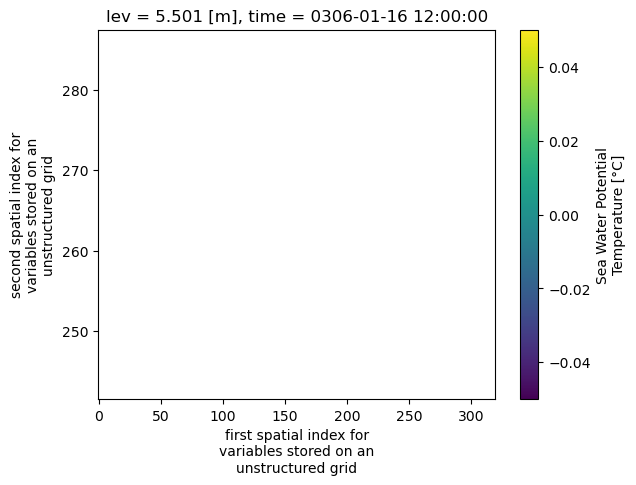

In [19]:
test.thetao.isel(time=0,lev=0).plot(robust=True)